In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
finesse.configure(plotting=True)

power = 1.5  # default laser power in Watt
w0 = 10e-3   # default gaussian waist size in meter3
alpha = 30   # angle of incidence for both BS in degrees0
xbeta = 1e-5 # default tilt of both beam splitters in radians
s1 = 1000    # distance till 1st beamsplitter
s2 = 400     # distance between beamsplitters
s3 = 600     # default distance between 2nd beamsplitter and detector
z0 = -1200   # default waist position, 1200 meter right of laser
maxtem = 7   # default maxtem

basescript = f"""
laser l1 P={power}
gauss g1 l1.p1.o w0={w0} z={z0}
modes(maxtem={maxtem})

space s1 l1.p1 bs1.p1 L={s1}
beamsplitter bs1 R=1 T=0 alpha={alpha} xbeta={xbeta}
space s2 bs1.p2 bs2.p1 L={s2}
beamsplitter bs2 R=1 T=0 alpha=bs1.alpha xbeta=bs1.xbeta
space s3 bs2.p2 n1.p1 L={s3}

# Add a 'nothing' component at the location of the detector
nothing n1
"""

basekat = finesse.Model()
basekat.parse(basescript)

In [2]:
# Simulations: measure beam 600 and 1000 meter after second BS
s3a = 600
s3b = 1000

kat1 = finesse.Model()
kat1.parse(basescript)

script1 = f"""
# Set a 1-D CCD at n1, measure around peak at 0.8 at 600 and 1000m
ccdline ccd1 node=n1.p1.i xlim=[0.5,1.0] npts=200
# Also put a full 2-D CCD at the same position
ccd ccd2 node=n1.p1.i xlim=[-3,3] ylim=[-3,3] npts=200

series(
    noxaxis(name="S600"),
    change(s3.L={s3b}),
    noxaxis(name="S1000")
)
"""

kat1.parse(script1)
out1 = kat1.run()

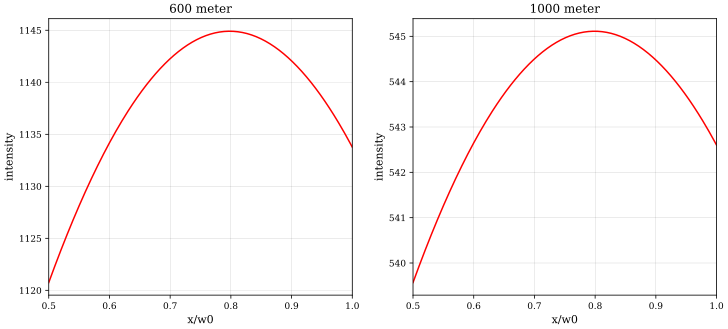

In [3]:
# Plot the results
f,ax = plt.subplots(ncols=2, figsize=(12, 5))
for (i, name, s3val) in ([0, 'S600', s3a], [1, 'S1000', s3b]):
    ax[i].plot(kat1.ccd1.xdata, out1[name]['ccd1'],'r')
    ax[i].set_title(f"{s3val:.0f} meter")
    ax[i].set_xlabel("x/w0")
    ax[i].set_ylabel("intensity")

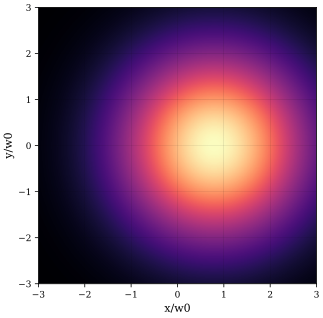

In [4]:
f,ax = plt.subplots(ncols=1, figsize=(5, 5))
pxy_extent = (kat1.ccd2.xdata.min(), kat1.ccd2.xdata.max(),
              kat1.ccd2.ydata.min(), kat1.ccd2.ydata.max())
ax.imshow(out1['S600']['ccd2'].T, aspect='auto', extent = pxy_extent)
ax.set_xlabel("x/w0")
ax.set_ylabel("y/w0");

In [5]:
# Plotting range for x: [peak-dx...peak+dx]
dx = 0.8

# Calculate expected Delta and delta phi
Delta = s2*np.sin(2*xbeta)/w0
dphi = 2*s2*np.sin(xbeta)**2/basekat.lambda0*360

kat2 = finesse.Model()
kat2.parse(basescript)

script2 = f"""
fline fl1 node=n1.p1.i xlim=[{Delta}-{dx},{Delta}+{dx}] npts=200
fline fl2 node=n1.p1.i xlim=[-{dx},{dx}] npts=40

series(
    noxaxis(name='full'),
    change(bs1.xbeta=0),
    noxaxis(name='ref')
)
"""
kat2.parse(script2)
out2 = kat2.run()

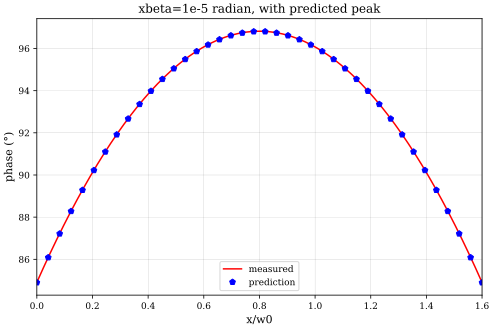

In [6]:
f,ax = plt.subplots(ncols=1, figsize=(8, 5))

ax.plot(kat2.fl1.xdata,
        np.angle(out2['full']['fl1'], deg=True),
        'r', label="measured")
ax.plot(kat2.fl2.xdata + Delta,
        np.angle(out2['ref']['fl2'], deg=True) + dphi,
        'bp', label="prediction")
ax.set_title("xbeta=1e-5 radian, with predicted peak")
ax.set_xlabel("x/w0")
ax.set_ylabel("phase (°)")
ax.legend(loc='lower center');

In [7]:
kat3 = finesse.Model()
kat3.parse(basescript)

script3 = """
# Note: important to specify n,m
amplitude_detector ad1 node=n1.p1.i f=0 n=0 m=0
xaxis(bs1.xbeta, lin, -1.5e-5, 1.5e-5, 40)
"""

kat3.parse(script3)
out3 = kat3.run()

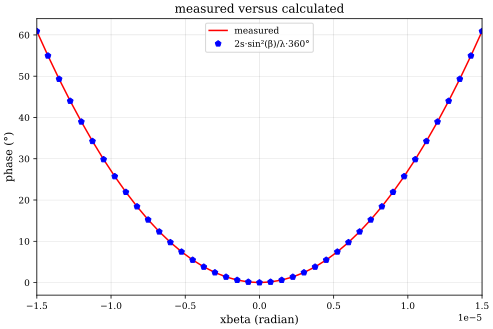

In [8]:
f,ax = plt.subplots(ncols=1, figsize=(8, 5))

ax.plot(out3.x[0], np.angle(out3['ad1'], deg=True),
        'r', label="measured")
ax.plot(out3.x[0], 2*s2*np.sin(out3.x[0])**2/basekat.lambda0*360,
        'bp', label="2s·sin²(β)/λ·360°")
ax.set_title("measured versus calculated")
ax.set_xlabel("xbeta (radian)")
ax.set_ylabel("phase (°)")
ax.legend(loc="upper center");